In [4]:
# استيراد المكتبات الأساسية
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
from tqdm import tqdm  # لاظهار الوقت tqdm

import folium
import folium.plugins
import branca.colormap as cm

import plotly.graph_objects as go  
import plotly.offline as py

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score , StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor , RandomForestClassifier , GradientBoostingClassifier ,HistGradientBoostingRegressor
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor , DecisionTreeClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.naive_bayes import GaussianNB


import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor


import warnings
warnings.filterwarnings('ignore')

# اعدادات لعرض البيانات بشكل افضل
pd.set_option('display.max_columns', None)  # عرض جميع الاعمدة
pd.set_option('display.width', 1000)  # عرض اوسع للجداول

In [5]:
# CSV تحميل البيانات من ملف 
try:
    df = pd.read_csv(r'E:\ML Models\PROJECT 3\oil_pipeline_leakage\database.csv')
except FileNotFoundError:
    print("تأكد من وجود ملف البيانات 'database.csv' في المسار الصحيح.")
    exit()

df.head()
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 48 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Report Number                         2795 non-null   int64  
 1   Supplemental Number                   2795 non-null   int64  
 2   Accident Year                         2795 non-null   int64  
 3   Accident Date/Time                    2795 non-null   object 
 4   Operator ID                           2795 non-null   int64  
 5   Operator Name                         2795 non-null   object 
 6   Pipeline/Facility Name                2674 non-null   object 
 7   Pipeline Location                     2795 non-null   object 
 8   Pipeline Type                         2777 non-null   object 
 9   Liquid Type                           2795 non-null   object 
 10  Liquid Subtype                        1349 non-null   object 
 11  Liquid Name      

# Some Data Analysis for database.csv

###  Accidents by Operator:

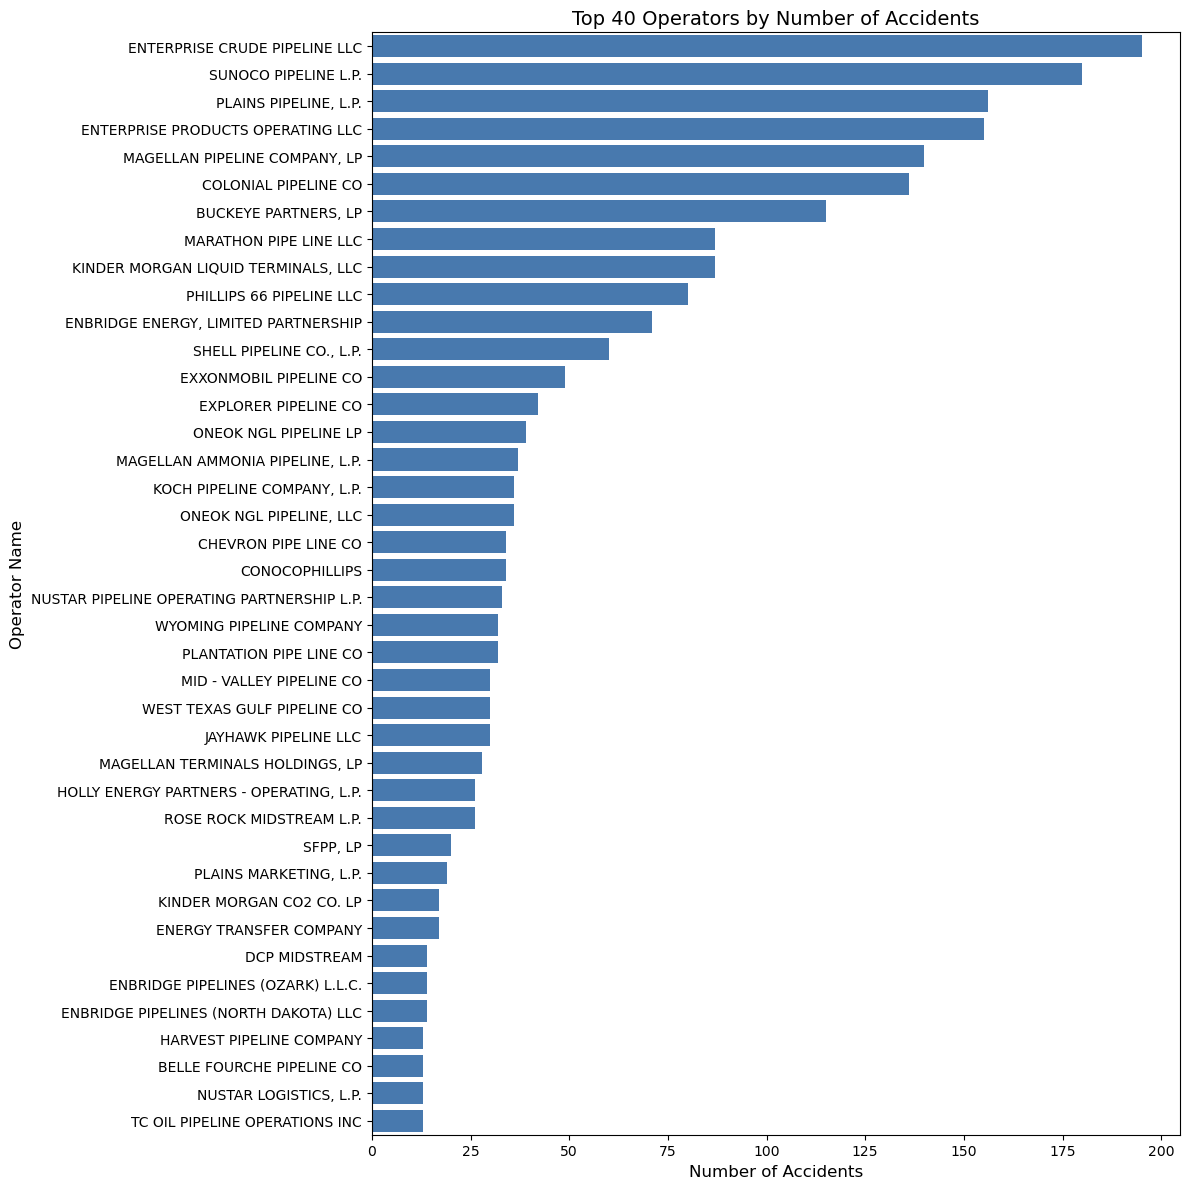

In [6]:
operator_counts = df['Operator Name'].value_counts()

n_display = 40 
operator_counts_sorted = operator_counts.head(n_display)

plt.figure(figsize=(12, 12)) 
sns.barplot(x=operator_counts_sorted.values, y=operator_counts_sorted.index, color="#3778bf")

plt.xlabel("Number of Accidents", fontsize=12)
plt.ylabel("Operator Name", fontsize=12)
plt.title(f"Top {n_display} Operators by Number of Accidents", fontsize=14)

plt.tight_layout()

plt.show()

### Accidents by location


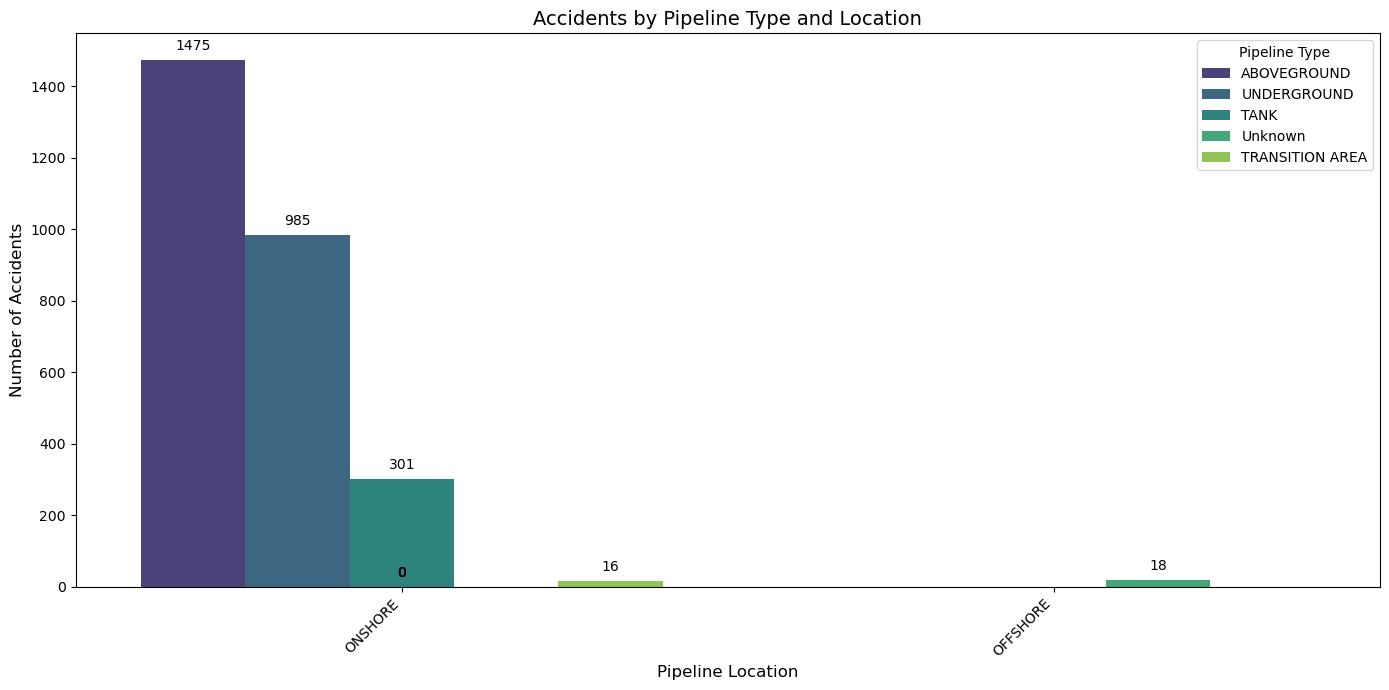

In [7]:
df_plot = df[['Pipeline Location', 'Pipeline Type']].copy()

df_plot['Pipeline Type'].fillna("Unknown", inplace=True)
df_plot['Pipeline Location'].fillna("Unknown", inplace=True)

df_plot = df_plot[df_plot['Pipeline Location'] != "Unknown"]

df_plot['Pipeline Location'] = df_plot['Pipeline Location'].str.strip()
df_plot['Pipeline Type'] = df_plot['Pipeline Type'].str.strip()


plt.figure(figsize=(14, 7))  
ax = sns.countplot(x='Pipeline Location', hue='Pipeline Type', data=df_plot, palette='viridis')

for p in ax.patches:
    height = p.get_height()
    if pd.isna(height):
        height = 0
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel("Pipeline Location", fontsize=12)
plt.ylabel("Number of Accidents", fontsize=12)
plt.title("Accidents by Pipeline Type and Location", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title='Pipeline Type', loc='upper right')
plt.tight_layout()
plt.show()

<Axes: xlabel='count', ylabel='Pipeline Type'>

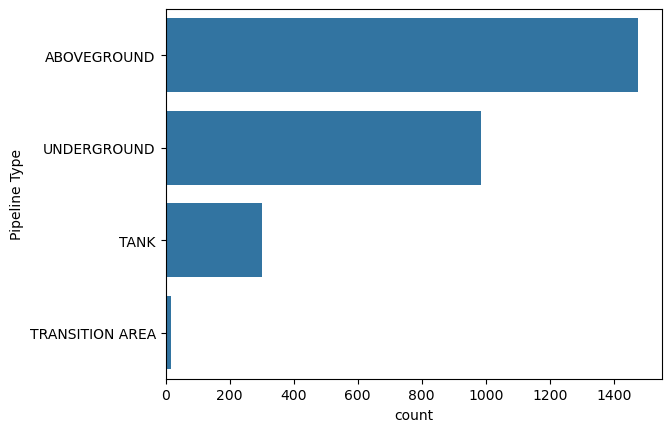

In [8]:
sns.countplot(df['Pipeline Type'])

#### Which Pipeline Type has highest cost

<Axes: xlabel='Pipeline Type', ylabel='All Costs'>

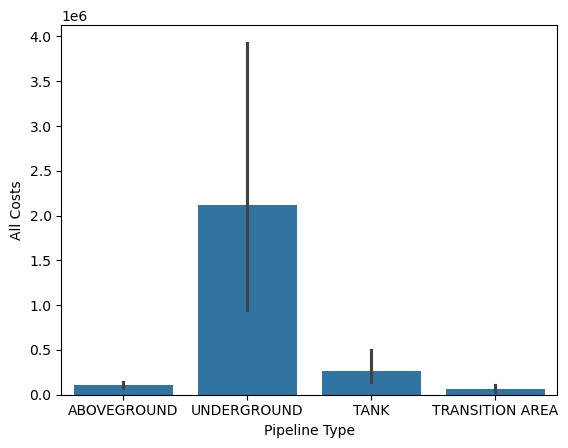

In [9]:
df_PipeLine_Type_All_Cost = df[['Pipeline Type','All Costs']]
sns.barplot(x='Pipeline Type', y="All Costs",  data=df_PipeLine_Type_All_Cost)

#### Most common location that the accident happend

In [11]:
df_plot_map = df.copy()

# 1. Handle missing values (critical for lat/lon)
df_plot_map.dropna(subset=['Accident Latitude', 'Accident Longitude'], inplace=True)

# 2. Remove rows with invalid coordinates.
df_plot_map = df_plot_map[
    (df_plot_map['Accident Latitude'] >= -90) & (df_plot_map['Accident Latitude'] <= 90) &
    (df_plot_map['Accident Longitude'] >= -180) & (df_plot_map['Accident Longitude'] <= 180)
]

# --- Prepare Data for Heatmap ---
# Create a DataFrame with just lat, lon, and a count of 1 for each accident
heatmap_data = df_plot_map[['Accident Latitude', 'Accident Longitude']].copy()
heatmap_data['count'] = 1  # Add a count column


# --- Create the Folium Map ---

# 1. Base Map
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)  # Center on the US

# 2. Add Heatmap Layer
# Convert the data to a list of (lat, lon, weight)
heat_data = [[row['Accident Latitude'], row['Accident Longitude'], row['count']] for index, row in heatmap_data.iterrows()]

# Add the heatmap
folium.plugins.HeatMap(heat_data).add_to(m)

# 3. Add State Outlines (Choropleth, but without value-based coloring)
geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json'

folium.GeoJson(
    geojson_url,
    name='geojson',
    style_function=lambda feature: {
        'fillColor': 'grey',  # Light grey fill
        'color': 'black',     # Black outline
        'weight': 1,          # Thin line
        'fillOpacity': 0.1,  # Make fill very transparent
    }
).add_to(m)


# 4. Add Layer Control (Optional)
folium.LayerControl().add_to(m)

# --- Display the Map ---
m


### Cause Subcategory Analysis

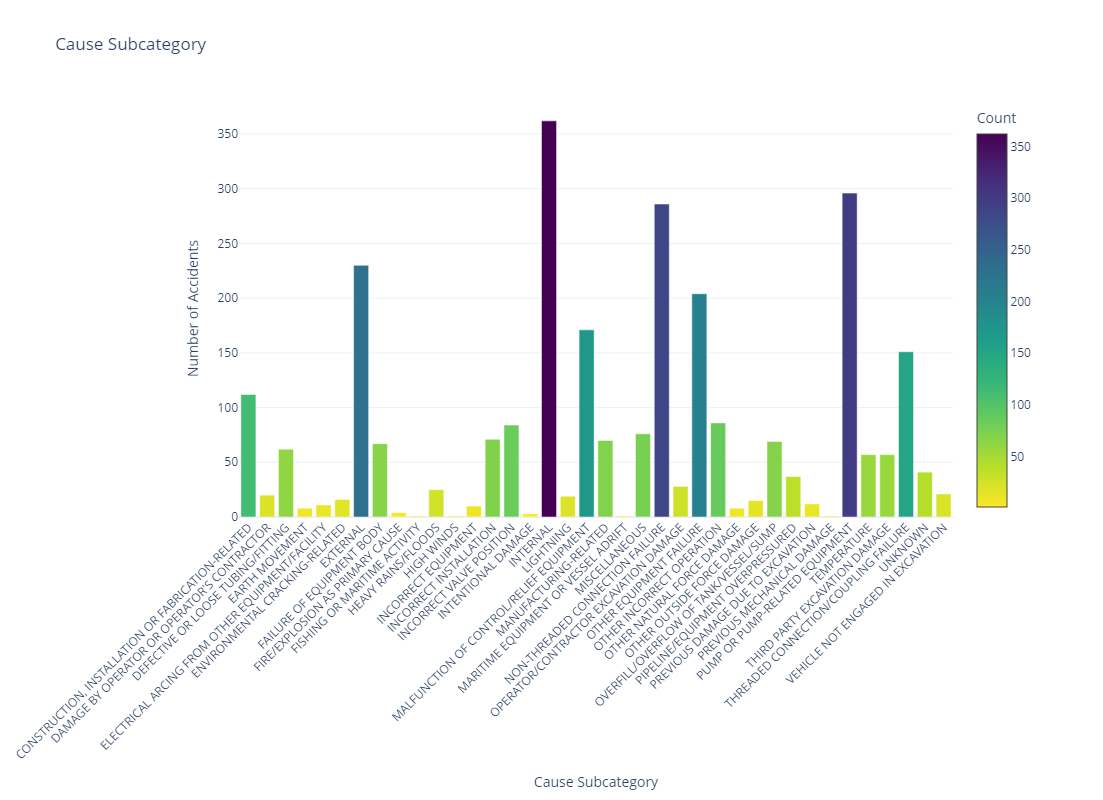

In [12]:
#Clean up the data, remove the columns which lack informaiton
oil = df.copy()

oil = oil.drop(columns=['Operator Employee Injuries', 'Operator Contractor Injuries','Emergency Responder Injuries','Other Injuries','Public Injuries'
                        ,'All Injuries','Operator Employee Fatalities','Emergency Responder Fatalities','Other Fatalities','Public Fatalities','All Fatalities'
                        ,'Operator Contractor Fatalities','Liquid Name'])
oil = oil.drop([2793,2794])
main_causes_sub = oil.groupby('Cause Subcategory').size().reset_index(name='count')

# --- Plotly Bar Chart Creation ---

# Use go.Bar directly (the correct way in recent Plotly versions)
fig = go.Figure(data=[
    go.Bar(
        y=main_causes_sub['count'],       
        x=main_causes_sub['Cause Subcategory'],  
        name='Causes Subcategory Count',
        marker=dict(
            color=main_causes_sub['count'],    
            colorscale='Viridis',
            reversescale=True,
            colorbar=dict(title='Count')))])

# Update layout for better readability
fig.update_layout(
    title='Cause Subcategory',
    xaxis_title="Cause Subcategory",  # Add x-axis label
    yaxis_title="Number of Accidents", # Add y-axis label
    width=1200,
    height=800,
    margin=dict(b=150, r=150),     # Adjust margins for labels
    xaxis_tickangle=-45,            # Rotate x-axis labels for readability
    template="plotly_white"      # Use white template
)

# Display the plot
fig.show()

# --- المعالجة البيانات  ---

##### سنعتبر الأعمدة التي لديها قيم مفقودة في أكثر من 50% من البيانات أعمدة غير مكتملة بشكل كبير

In [13]:
# 1. التعامل مع القيم المفقودة:
cols_to_drop = ['Liquid Subtype', 'Liquid Name',
                'Intentional Release (Barrels)', 'Operator Employee Injuries', 'Operator Contractor Injuries',
                'Emergency Responder Injuries', 'Public Injuries', 'All Injuries',
                'Operator Employee Fatalities', 'Operator Contractor Fatalities', 'Emergency Responder Fatalities',
                'Other Fatalities','Public Fatalities','All Fatalities','Other Injuries']
df.drop(columns=cols_to_drop, inplace=True)

future_date = pd.to_datetime('2099-01-01')
df['Shutdown Date/Time'].fillna(future_date, inplace=True)
df['Restart Date/Time'].fillna(future_date, inplace=True)

categorical_cols = ['Operator Name', 'Pipeline Location', 'Pipeline Type', 'Liquid Type',
                    'Liquid Subtype', 'Liquid Name', 'Cause Subcategory',
                    'Accident City', 'Accident County', 'Accident State', 'Pipeline/Facility Name']

In [14]:
#2. هندسة الخصائص :

df['Accident Date/Time'] = pd.to_datetime(df['Accident Date/Time'])

# استخراج خصائص التاريخ والوقت
df['Accident_Year'] = df['Accident Date/Time'].dt.year
df['Accident_Month'] = df['Accident Date/Time'].dt.month
df['Accident_Day'] = df['Accident Date/Time'].dt.day
df['Accident_Hour'] = df['Accident Date/Time'].dt.hour
df['Accident_DayOfWeek'] = df['Accident Date/Time'].dt.dayofweek


df['Shutdown Date/Time'] = pd.to_datetime(df['Shutdown Date/Time'])
df['Restart Date/Time'] = pd.to_datetime(df['Restart Date/Time'])

# حساب المسافة من متوسط خطوط العرض والطول
df['Lat_Lon_Distance'] = np.sqrt((df['Accident Latitude'] - df['Accident Latitude'].mean())**2 +
                                  (df['Accident Longitude'] - df['Accident Longitude'].mean())**2)


# خاصية تفاعلية('YES'/'NO' إلى 1/0)
df['Net_Loss_Ignition'] = df['Net Loss (Barrels)'] * df['Liquid Ignition'].map({'YES': 1, 'NO': 0})


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 40 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Report Number                         2795 non-null   int64         
 1   Supplemental Number                   2795 non-null   int64         
 2   Accident Year                         2795 non-null   int64         
 3   Accident Date/Time                    2795 non-null   datetime64[ns]
 4   Operator ID                           2795 non-null   int64         
 5   Operator Name                         2795 non-null   object        
 6   Pipeline/Facility Name                2674 non-null   object        
 7   Pipeline Location                     2795 non-null   object        
 8   Pipeline Type                         2777 non-null   object        
 9   Liquid Type                           2795 non-null   object        
 10  

# --- التعامل مع القيم المفقودة ---


In [15]:
# 1. الأعمدة الفئوية (Categorical Columns)

# قائمة الأعمدة الفئوية التي بها قيم مفقودة
categorical_cols_with_missing = ['Pipeline/Facility Name', 'Pipeline Type', 'Accident City', 'Accident County', 'Accident State','Pipeline Shutdown']

# لملء القيم المفقودة بالقيمة الأكثر تكرارًا
imputer_categorical = SimpleImputer(strategy='most_frequent')

if len(categorical_cols_with_missing) > 0:
    df[categorical_cols_with_missing] = imputer_categorical.fit_transform(df[categorical_cols_with_missing])


# 2. الأعمدة الرقمية (Numerical Columns)

# قائمة الأعمدة الرقمية التي بها قيم مفقودة (وتم اختيارها للنماذج)
numerical_cols_with_missing = ['Public Evacuations', 'Property Damage Costs',
                               'Lost Commodity Costs', 'Public/Private Property Damage Costs',
                               'Emergency Response Costs', 'Environmental Remediation Costs',
                               'Other Costs']

# استخدام IterativeImputer لملء القيم المفقودة باستخدام نموذج RandomForestRegressor
# يمكن تجربة نماذج أخرى مثل LinearRegression أو KNNImputer
imputer_numerical = IterativeImputer(RandomForestRegressor(n_estimators=5,random_state=42),
                                    max_iter=10, random_state=42,n_nearest_features=5) #اضافة  n_nearest_features

# تطبيق التحويل على الأعمدة المحددة فقط
if len(numerical_cols_with_missing) > 0:
    df[numerical_cols_with_missing] = imputer_numerical.fit_transform(df[numerical_cols_with_missing])



# --- تحويل البيانات النصية الي عددية ---

In [16]:
categorical_columns = ['Operator Name', 'Pipeline/Facility Name', 'Pipeline Location',
                       'Pipeline Type', 'Liquid Type', 'Accident City', 'Accident County',
                       'Accident State', 'Cause Subcategory',
                       'Liquid Ignition', 'Liquid Explosion', 'Pipeline Shutdown']

label_encoder = LabelEncoder()

for column in categorical_columns:
    df[column] = df[column].astype(str)
    df[column] = label_encoder.fit_transform(df[column])

df[categorical_columns].head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 40 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Report Number                         2795 non-null   int64         
 1   Supplemental Number                   2795 non-null   int64         
 2   Accident Year                         2795 non-null   int64         
 3   Accident Date/Time                    2795 non-null   datetime64[ns]
 4   Operator ID                           2795 non-null   int64         
 5   Operator Name                         2795 non-null   int32         
 6   Pipeline/Facility Name                2795 non-null   int32         
 7   Pipeline Location                     2795 non-null   int32         
 8   Pipeline Type                         2795 non-null   int32         
 9   Liquid Type                           2795 non-null   int32         
 10  

In [17]:
X = df.drop(['Report Number', 'Supplemental Number','Accident Date/Time','Shutdown Date/Time','Restart Date/Time',
             'Unintentional Release (Barrels)', 'Liquid Ignition', 'Liquid Explosion', 'Cause Category',
             'Property Damage Costs', 'Lost Commodity Costs', 'Public/Private Property Damage Costs',
             'Emergency Response Costs', 'Environmental Remediation Costs', 'Other Costs', 'All Costs'], axis=1) # كل الأعمدة ما عدا الهدف
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Accident Year              2795 non-null   int64  
 1   Operator ID                2795 non-null   int64  
 2   Operator Name              2795 non-null   int32  
 3   Pipeline/Facility Name     2795 non-null   int32  
 4   Pipeline Location          2795 non-null   int32  
 5   Pipeline Type              2795 non-null   int32  
 6   Liquid Type                2795 non-null   int32  
 7   Accident City              2795 non-null   int32  
 8   Accident County            2795 non-null   int32  
 9   Accident State             2795 non-null   int32  
 10  Accident Latitude          2795 non-null   float64
 11  Accident Longitude         2795 non-null   float64
 12  Cause Subcategory          2795 non-null   int32  
 13  Liquid Recovery (Barrels)  2795 non-null   float

In [18]:
# قائمة بجميع الأعمدة الرقمية (بعد Label Encoding وبعد هندسة الخصائص)
numerical_columns = [col for col in X.columns if X[col].dtype in ['int64', 'float64', 'int32']]

# تهيئة StandardScaler
scaler = StandardScaler()

# تطبيق التحويل على الأعمدة الرقمية
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# عرض البيانات بعد التحويل (أول 5 صفوف)
X[numerical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Accident Year              2795 non-null   float64
 1   Operator ID                2795 non-null   float64
 2   Operator Name              2795 non-null   float64
 3   Pipeline/Facility Name     2795 non-null   float64
 4   Pipeline Location          2795 non-null   float64
 5   Pipeline Type              2795 non-null   float64
 6   Liquid Type                2795 non-null   float64
 7   Accident City              2795 non-null   float64
 8   Accident County            2795 non-null   float64
 9   Accident State             2795 non-null   float64
 10  Accident Latitude          2795 non-null   float64
 11  Accident Longitude         2795 non-null   float64
 12  Cause Subcategory          2795 non-null   float64
 13  Liquid Recovery (Barrels)  2795 non-null   float

In [19]:
# 1. نموذج التنبؤ بحجم التسرب
y_leak_size = df['Unintentional Release (Barrels)']

# 2. نموذج تصنيف سبب التسرب
y_leak_cause = df['Cause Category']

# 3. نموذج التنبؤ بالتكاليف (يمكن التنبؤ بتكلفة واحدة أو أكثر)
y_costs = df['All Costs']  # التكلفة الإجمالية

In [20]:
# 1. نموذج التنبؤ بحجم التسرب
X_train_leak_size, X_test_leak_size, y_train_leak_size, y_test_leak_size = train_test_split(
    X, y_leak_size, test_size=0.2, random_state=42)

# 2. نموذج تصنيف سبب التسرب
X_train_leak_cause, X_test_leak_cause, y_train_leak_cause, y_test_leak_cause = train_test_split(
    X, y_leak_cause, test_size=0.2, random_state=42)

In [21]:
y_leak_cause

0               INCORRECT OPERATION
1       MATERIAL/WELD/EQUIP FAILURE
2       MATERIAL/WELD/EQUIP FAILURE
3              NATURAL FORCE DAMAGE
4                 EXCAVATION DAMAGE
                   ...             
2790    MATERIAL/WELD/EQUIP FAILURE
2791               ALL OTHER CAUSES
2792    MATERIAL/WELD/EQUIP FAILURE
2793               ALL OTHER CAUSES
2794            INCORRECT OPERATION
Name: Cause Category, Length: 2795, dtype: object

# --- نموذج التنبؤ بحجم التسرب ---

In [22]:
# 1. RandomForestRegressor مع GridSearchCV
print("\nRandomForestRegressor (Size Prediction):")
model_size = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)  # قيم افتراضية
model_size.fit(X_train_leak_size, y_train_leak_size)
y_size_pred = model_size.predict(X_test_leak_size)
rmse_size = np.sqrt(mean_squared_error(y_test_leak_size, y_size_pred))
r2_size = r2_score(y_test_leak_size, y_size_pred)
print(f"  RMSE (Validation): {rmse_size:.2f}")
print(f"  R-squared (Validation): {r2_size:.2f}")

print("\nGradientBoostingRegressor (Size Prediction):")
model_size_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # قيم افتراضية
model_size_gb.fit(X_train_leak_size, y_train_leak_size)
y_size_pred_gb = model_size_gb.predict(X_test_leak_size)
rmse_size_gb = np.sqrt(mean_squared_error(y_test_leak_size, y_size_pred_gb))
r2_size_gb = r2_score(y_test_leak_size, y_size_pred_gb)
print(f"  RMSE (Validation): {rmse_size_gb:.2f}")
print(f"  R-squared (Validation): {r2_size_gb:.2f}")

print("SVR (Size Prediction):")
# 4. SVR (Support Vector Regressor)
model_size_svr = SVR() # قيم افتراضية
model_size_svr.fit(X_train_leak_size, y_train_leak_size)
y_size_pred_SVR = model_size_svr.predict(X_test_leak_size)
rmse_size_SVR = np.sqrt(mean_squared_error(y_test_leak_size, y_size_pred_SVR))
r2_size_SVR = r2_score(y_test_leak_size, y_size_pred_SVR)
print(f"  RMSE (Validation): {rmse_size_SVR:.2f}")
print(f"  R-squared (Validation): {r2_size_SVR:.2f}")

# 5. KNeighborsRegressor
print("KNeighborsRegressor (Size Prediction):")
model_size_KN = KNeighborsRegressor() # قيم افتراضية
model_size_KN.fit(X_train_leak_size, y_train_leak_size)
y_size_pred_KN = model_size_KN.predict(X_test_leak_size)
rmse_size_KN = np.sqrt(mean_squared_error(y_test_leak_size, y_size_pred_KN))
r2_size_KN = r2_score(y_test_leak_size, y_size_pred_KN)
print(f"  RMSE (Validation): {rmse_size_KN:.2f}")
print(f"  R-squared (Validation): {r2_size_KN:.2f}")

# 6. DecisionTreeRegressor
print("DecisionTreeRegressor (Size Prediction):")
model_size = DecisionTreeRegressor(random_state=42)  # قيم افتراضية
model_size.fit(X_train_leak_size, y_train_leak_size)
y_size_pred = model_size.predict(X_test_leak_size)
rmse_size = np.sqrt(mean_squared_error(y_test_leak_size, y_size_pred))
r2_size = r2_score(y_test_leak_size, y_size_pred)
print(f"  RMSE (Validation): {rmse_size:.2f}")
print(f"  R-squared (Validation): {r2_size:.2f}")

# 7. XGBRegressor
print("XGBRegressor (Size Prediction):")
xgbr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, objective='reg:squarederror')
xgbr.fit(X_train_leak_size, y_train_leak_size)
y_size_pred = xgbr.predict(X_test_leak_size)
rmse_size = np.sqrt(mean_squared_error(y_test_leak_size, y_size_pred))
r2_size = r2_score(y_test_leak_size, y_size_pred)
print(f"  RMSE (Validation): {rmse_size:.2f}")
print(f"  R-squared (Validation): {r2_size:.2f}")

# 8. HistGradientBoostingRegressor
print("HistGradientBoostingRegressor (Size Prediction):")
hist_gbr = HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1, max_depth=3, random_state=42)
hist_gbr.fit(X_train_leak_size, y_train_leak_size)
y_size_pred = hist_gbr.predict(X_test_leak_size)
rmse_size = np.sqrt(mean_squared_error(y_test_leak_size, y_size_pred))
r2_size = r2_score(y_test_leak_size, y_size_pred)
print(f"  RMSE (Validation): {rmse_size:.2f}")
print(f"  R-squared (Validation): {r2_size:.2f}")

print("CatBoostRegressor (Size Prediction):")
catbr = CatBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbose=0)
catbr.fit(X_train_leak_size, y_train_leak_size)
y_size_pred = catbr.predict(X_test_leak_size)
rmse_size = np.sqrt(mean_squared_error(y_test_leak_size, y_size_pred))
r2_size = r2_score(y_test_leak_size, y_size_pred)
print(f"  RMSE (Validation): {rmse_size:.2f}")
print(f"  R-squared (Validation): {r2_size:.2f}")


RandomForestRegressor (Size Prediction):
  RMSE (Validation): 743.02
  R-squared (Validation): 0.84

GradientBoostingRegressor (Size Prediction):
  RMSE (Validation): 591.67
  R-squared (Validation): 0.90
SVR (Size Prediction):
  RMSE (Validation): 1855.54
  R-squared (Validation): -0.02
KNeighborsRegressor (Size Prediction):
  RMSE (Validation): 911.14
  R-squared (Validation): 0.75
DecisionTreeRegressor (Size Prediction):
  RMSE (Validation): 604.16
  R-squared (Validation): 0.89
XGBRegressor (Size Prediction):
  RMSE (Validation): 763.33
  R-squared (Validation): 0.83
HistGradientBoostingRegressor (Size Prediction):
  RMSE (Validation): 1318.50
  R-squared (Validation): 0.49
CatBoostRegressor (Size Prediction):
  RMSE (Validation): 648.31
  R-squared (Validation): 0.88


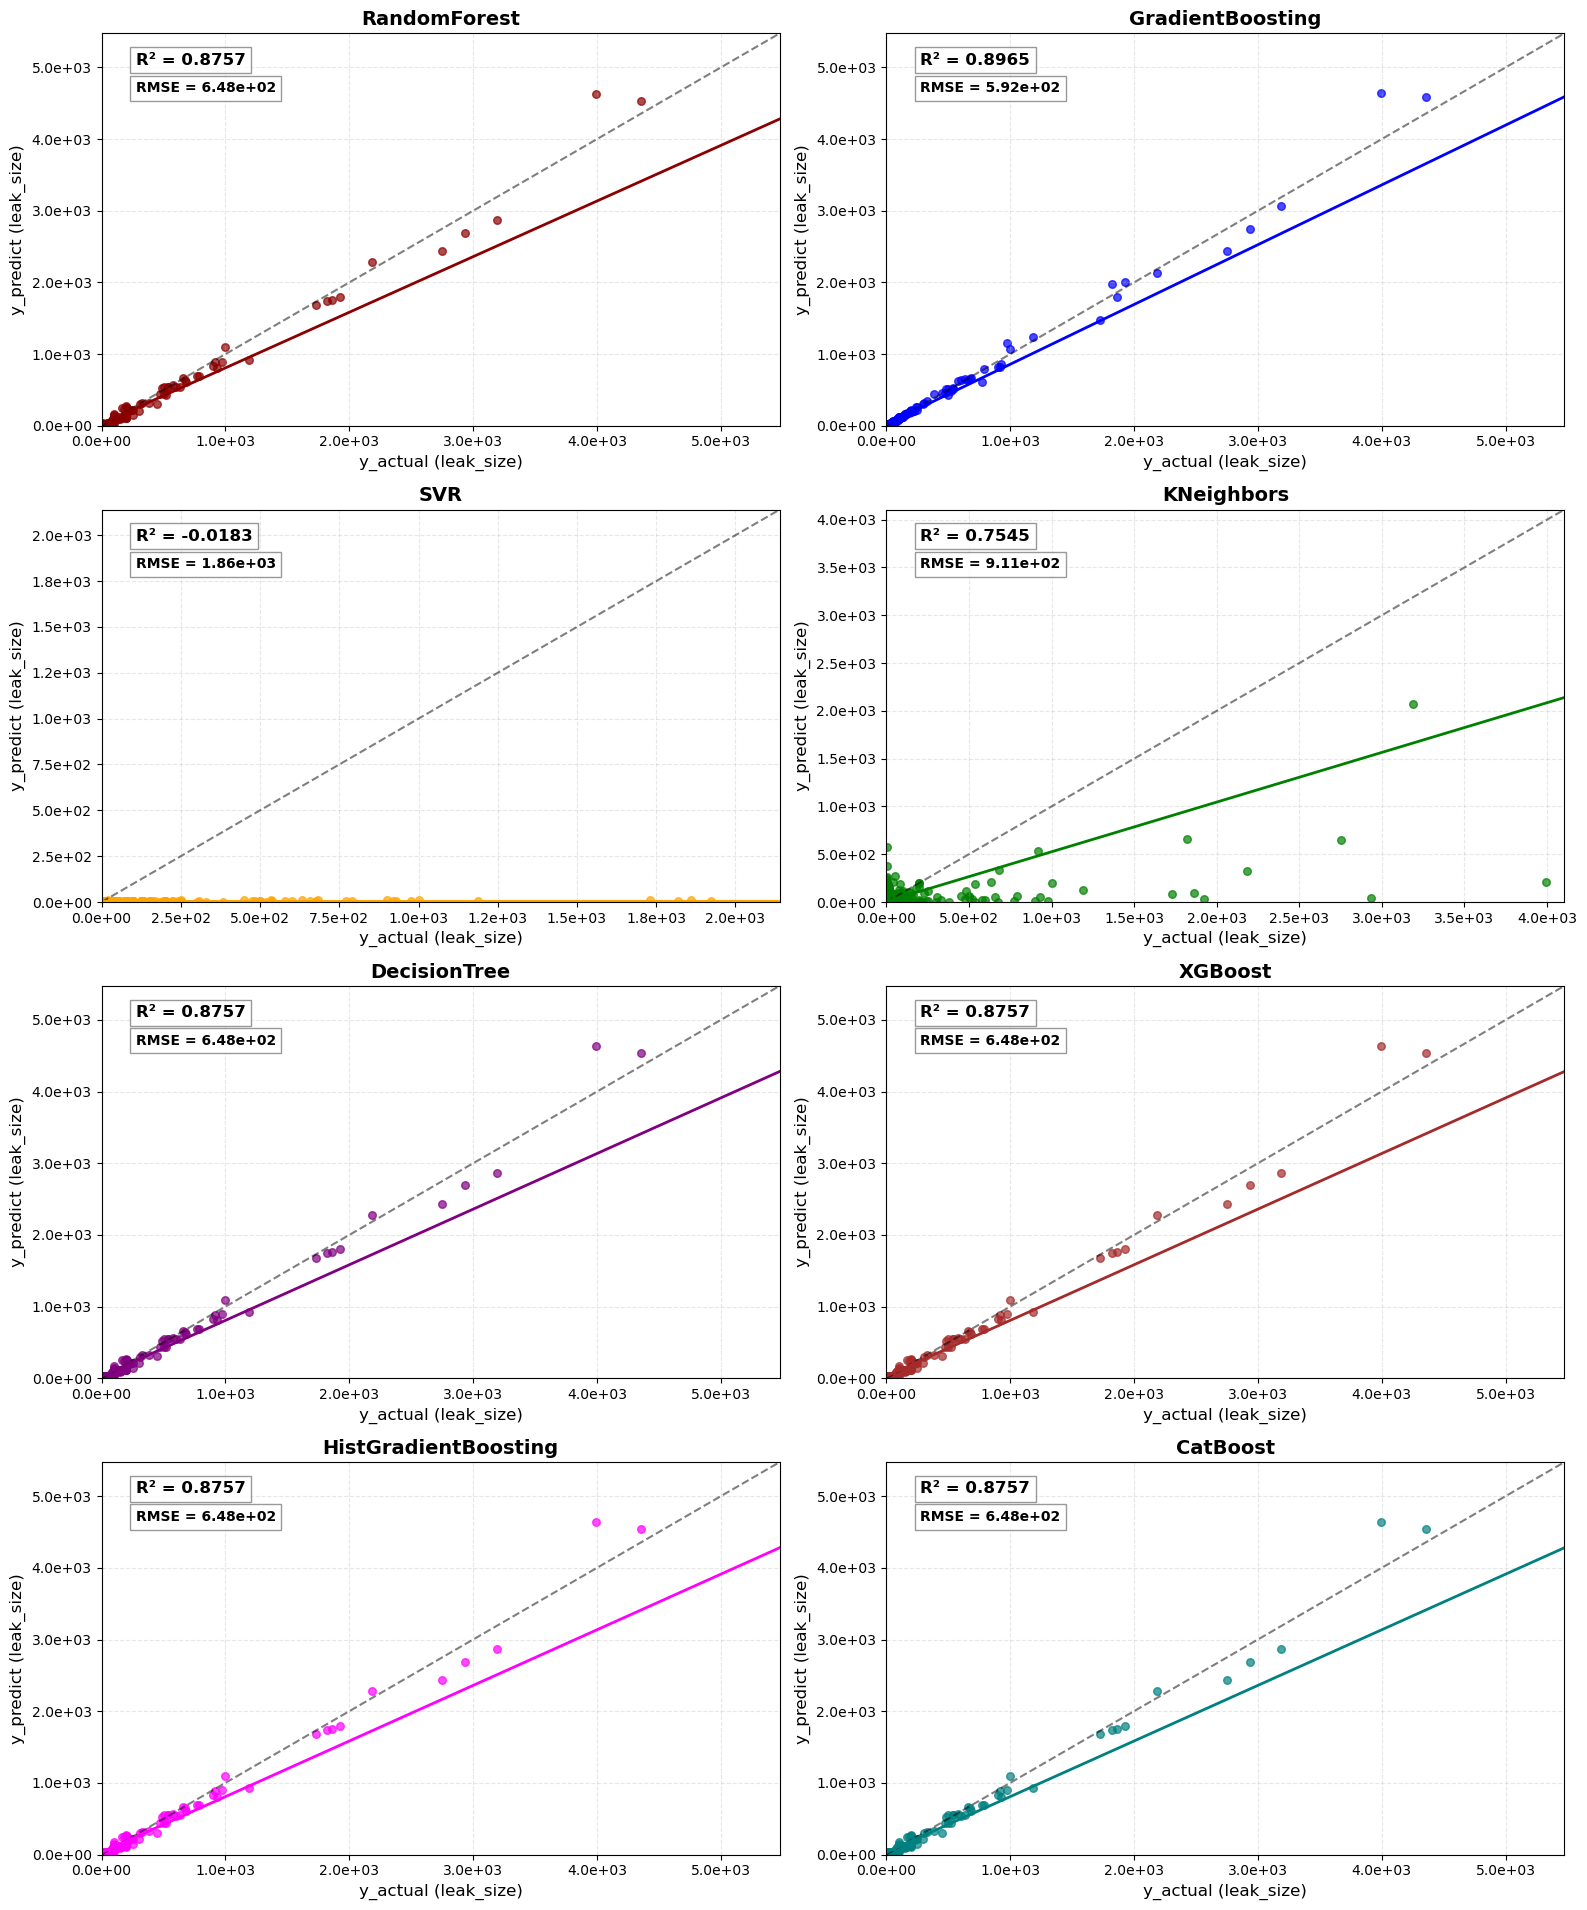

In [23]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))

# تعريف الخوارزميات والتنبؤات المقابلة مع قيم R-squared و RMSE
algorithms = [
    ('RandomForest', y_size_pred, y_test_leak_size, r2_size, rmse_size, 'darkred'),  # y_size_pred  بدون  _gb
    ('GradientBoosting', y_size_pred_gb, y_test_leak_size, r2_size_gb, rmse_size_gb, 'blue'), # y_size_pred_gb
    ('SVR', y_size_pred_SVR, y_test_leak_size, r2_size_SVR, rmse_size_SVR, 'orange'), # y_size_pred_SVR
    ('KNeighbors', y_size_pred_KN, y_test_leak_size, r2_size_KN, rmse_size_KN, 'green'), #y_size_pred_KN
    ('DecisionTree', y_size_pred, y_test_leak_size, r2_size, rmse_size, 'purple'), # y_size_pred بدون _dtr
    ('XGBoost', y_size_pred, y_test_leak_size, r2_size, rmse_size, 'brown'), # y_size_pred
    ('HistGradientBoosting', y_size_pred, y_test_leak_size, r2_size, rmse_size, 'magenta'), # y_size_pred
    ('CatBoost', y_size_pred, y_test_leak_size, r2_size, rmse_size, 'teal')  # y_size_pred
]

# رسم كل خوارزمية
for i, (name, y_pred, y_true, r2, rmse, color) in enumerate(algorithms):
    row, col = i // 2, i % 2
    ax = axes[row, col]

    # رسم البيانات
    ax.scatter(y_true, y_pred, alpha=0.7, s=30, color=color)

    # تحديد الحد الأقصى المشترك للمحاور (92% percentile)
    all_values = np.concatenate([y_true, y_pred])
    max_val = np.percentile(all_values, 99)

    # تعيين نطاق المحاور
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)

    # رسم خط الانحدار المثالي (y=x)
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

    # رسم خط الانحدار الفعلي
    coef = np.polyfit(y_true, y_pred, 1)
    poly1d_fn = np.poly1d(coef)
    ax.plot([0, max_val], [poly1d_fn(0), poly1d_fn(max_val)], '-', color=color, linewidth=2)
    
    # تنسيق المحاور لعرض القيم العلمية بطريقة أفضل
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.1e}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.1e}'))

    # إضافة قيمة R²
    ax.text(0.05, 0.92, f'R² = {r2:.4f}', transform=ax.transAxes,
            fontsize=12, fontweight='bold', color='black',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    # تسمية المحاور والعنوان
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.set_xlabel('y_actual (leak_size)', fontsize=12)
    ax.set_ylabel('y_predict (leak_size)', fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--')

     # إضافة RMSE
    ax.text(0.05, 0.85, f'RMSE = {rmse:.2e}', transform=ax.transAxes,
            fontsize=10, fontweight='bold', color='black',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))



# ضبط المساحات بين الرسوم البيانية
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('algorithms_size_predictions_comparison_with_r2_rmse.png', dpi=300, bbox_inches='tight')
plt.show()

# --- نموذج تصنيف سبب التسرب ---


RandomForestClassifier (Cause Prediction):
  Cross-Validation Accuracy: 0.78 (+/- 0.04)
  Accuracy (Validation): 0.81
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.86      0.50      0.63        24
                  CORROSION       0.82      0.93      0.88       106
          EXCAVATION DAMAGE       0.83      0.79      0.81        24
        INCORRECT OPERATION       0.78      0.56      0.65        80
MATERIAL/WELD/EQUIP FAILURE       0.80      0.92      0.86       292
       NATURAL FORCE DAMAGE       0.83      0.25      0.38        20
 OTHER OUTSIDE FORCE DAMAGE       1.00      0.08      0.14        13

                   accuracy                           0.81       559
                  macro avg       0.85      0.58      0.62       559
               weighted avg       0.81      0.81      0.79       559



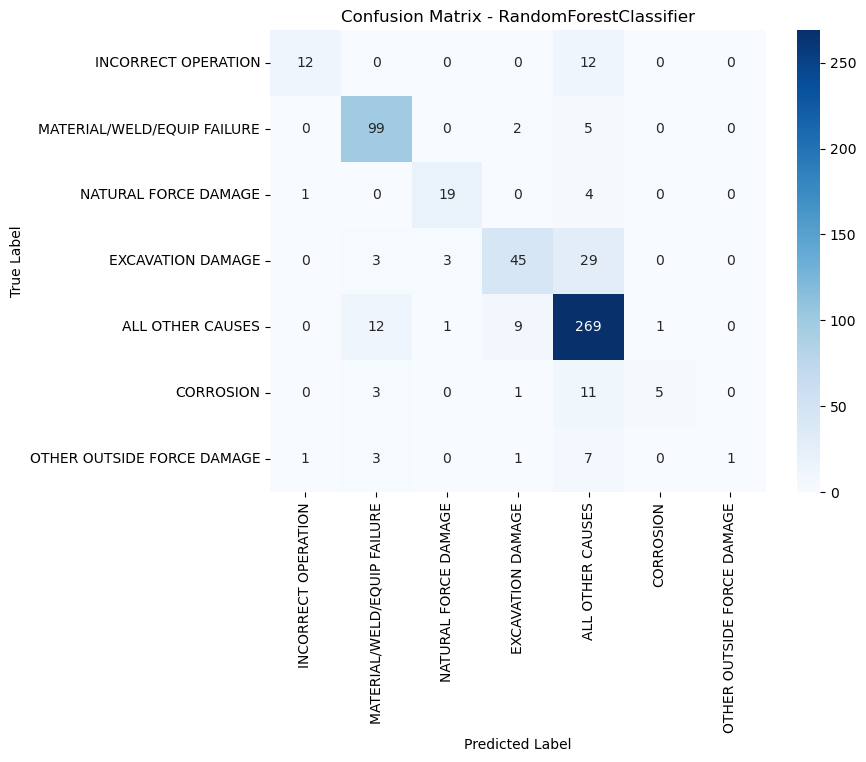


GradientBoostingClassifier (Cause Prediction):
  Cross-Validation Accuracy: 0.99 (+/- 0.02)
  Accuracy (Validation): 1.00
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.96      1.00      0.98        24
                  CORROSION       1.00      1.00      1.00       106
          EXCAVATION DAMAGE       1.00      0.96      0.98        24
        INCORRECT OPERATION       1.00      1.00      1.00        80
MATERIAL/WELD/EQUIP FAILURE       1.00      1.00      1.00       292
       NATURAL FORCE DAMAGE       1.00      1.00      1.00        20
 OTHER OUTSIDE FORCE DAMAGE       0.92      0.92      0.92        13

                   accuracy                           1.00       559
                  macro avg       0.98      0.98      0.98       559
               weighted avg       1.00      1.00      1.00       559



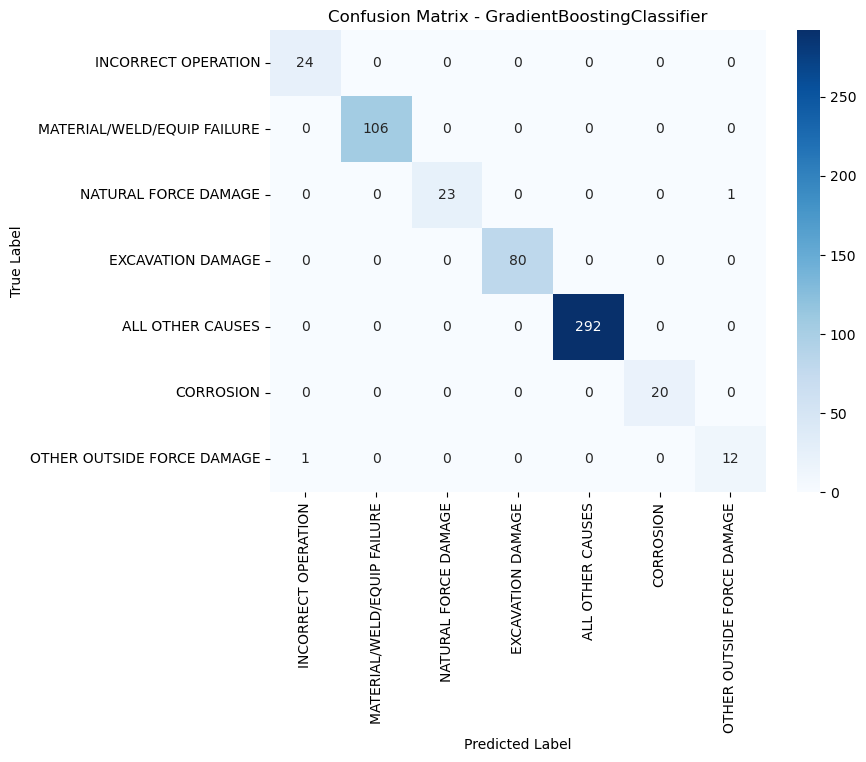


LogisticRegression (Cause Prediction):
  Cross-Validation Accuracy: 0.52 (+/- 0.02)
  Accuracy (Validation): 0.49
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.13      0.17      0.15        24
                  CORROSION       0.49      0.69      0.57       106
          EXCAVATION DAMAGE       0.40      0.71      0.52        24
        INCORRECT OPERATION       0.23      0.12      0.16        80
MATERIAL/WELD/EQUIP FAILURE       0.63      0.58      0.60       292
       NATURAL FORCE DAMAGE       0.07      0.05      0.06        20
 OTHER OUTSIDE FORCE DAMAGE       0.00      0.00      0.00        13

                   accuracy                           0.49       559
                  macro avg       0.28      0.33      0.29       559
               weighted avg       0.48      0.49      0.48       559



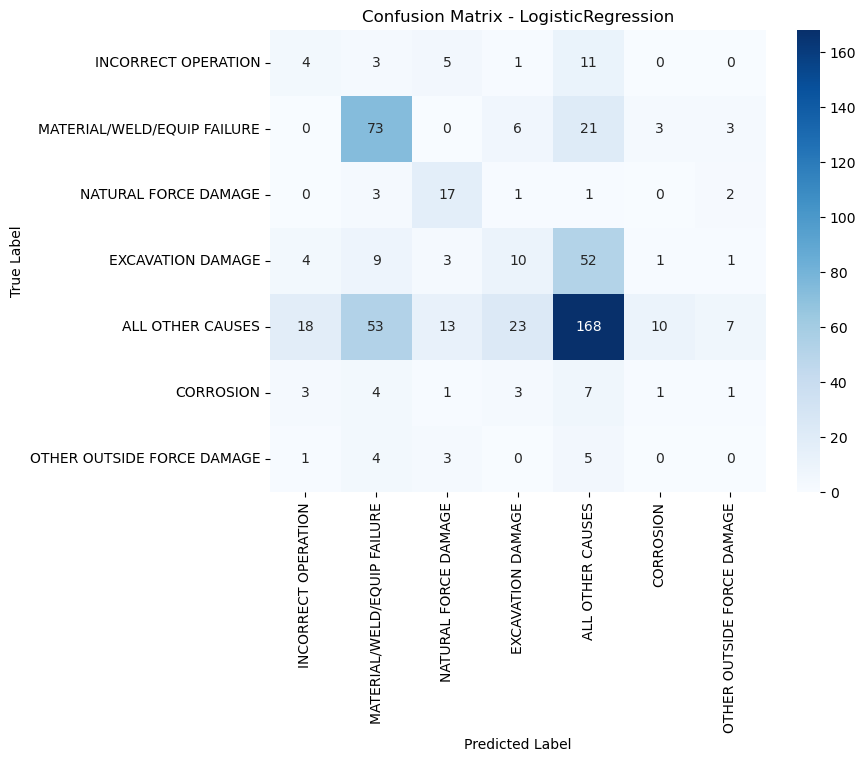


SVC (Cause Prediction):
  Cross-Validation Accuracy: 0.61 (+/- 0.02)
  Accuracy (Validation): 0.58
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.50      0.04      0.08        24
                  CORROSION       0.54      0.59      0.57       106
          EXCAVATION DAMAGE       0.76      0.54      0.63        24
        INCORRECT OPERATION       0.00      0.00      0.00        80
MATERIAL/WELD/EQUIP FAILURE       0.59      0.85      0.69       292
       NATURAL FORCE DAMAGE       0.00      0.00      0.00        20
 OTHER OUTSIDE FORCE DAMAGE       0.00      0.00      0.00        13

                   accuracy                           0.58       559
                  macro avg       0.34      0.29      0.28       559
               weighted avg       0.46      0.58      0.50       559



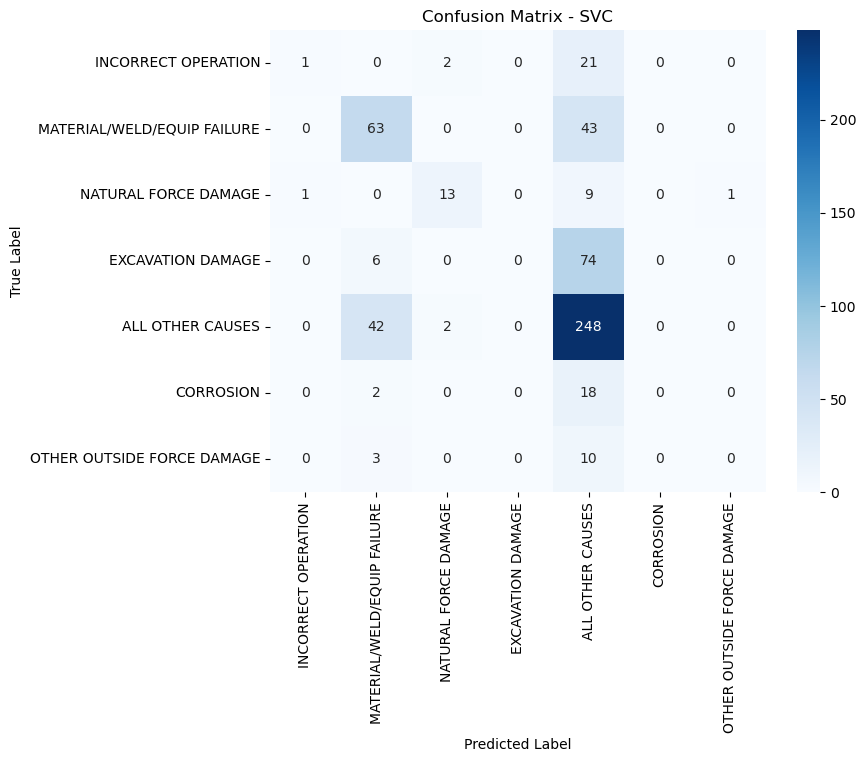


KNeighborsClassifier (Cause Prediction):
  Cross-Validation Accuracy: 0.54 (+/- 0.04)
  Accuracy (Validation): 0.51
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.06      0.04      0.05        24
                  CORROSION       0.45      0.54      0.49       106
          EXCAVATION DAMAGE       0.33      0.12      0.18        24
        INCORRECT OPERATION       0.28      0.23      0.25        80
MATERIAL/WELD/EQUIP FAILURE       0.61      0.71      0.65       292
       NATURAL FORCE DAMAGE       0.00      0.00      0.00        20
 OTHER OUTSIDE FORCE DAMAGE       0.00      0.00      0.00        13

                   accuracy                           0.51       559
                  macro avg       0.25      0.23      0.23       559
               weighted avg       0.46      0.51      0.48       559



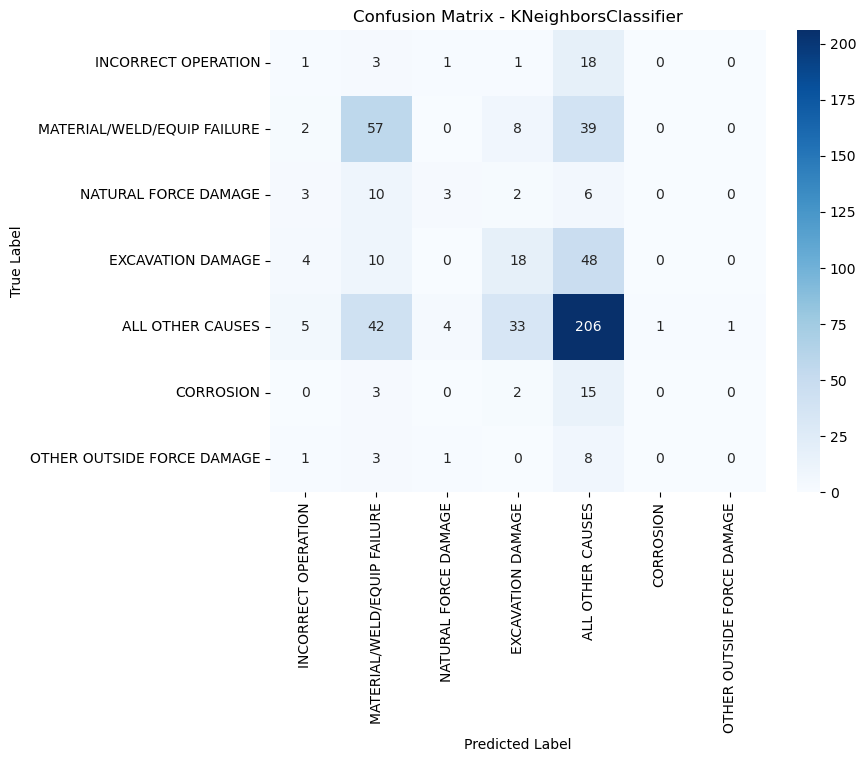


DecisionTreeClassifier (Cause Prediction):
  Cross-Validation Accuracy: 0.96 (+/- 0.03)
  Accuracy (Validation): 0.96
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.96      1.00      0.98        24
                  CORROSION       0.95      0.96      0.96       106
          EXCAVATION DAMAGE       0.96      0.92      0.94        24
        INCORRECT OPERATION       0.94      0.94      0.94        80
MATERIAL/WELD/EQUIP FAILURE       0.99      0.99      0.99       292
       NATURAL FORCE DAMAGE       0.76      0.80      0.78        20
 OTHER OUTSIDE FORCE DAMAGE       0.75      0.69      0.72        13

                   accuracy                           0.96       559
                  macro avg       0.90      0.90      0.90       559
               weighted avg       0.96      0.96      0.96       559



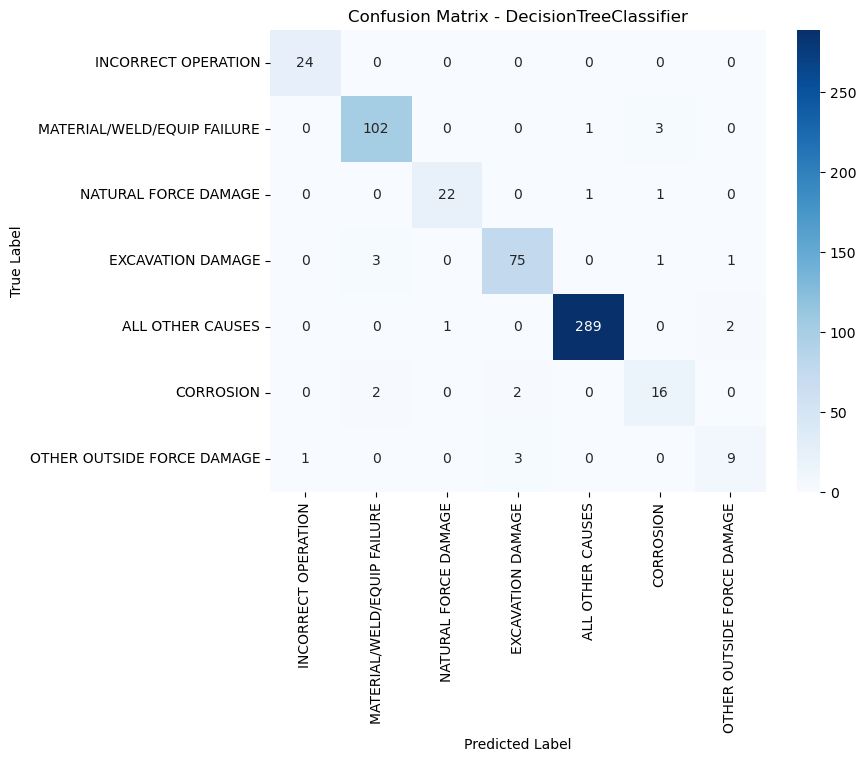


GaussianNB (Cause Prediction):
  Cross-Validation Accuracy: 0.16 (+/- 0.09)
  Accuracy (Validation): 0.15
                             precision    recall  f1-score   support

           ALL OTHER CAUSES       0.00      0.00      0.00        24
                  CORROSION       0.67      0.04      0.07       106
          EXCAVATION DAMAGE       0.00      0.00      0.00        24
        INCORRECT OPERATION       0.15      0.99      0.26        80
MATERIAL/WELD/EQUIP FAILURE       0.00      0.00      0.00       292
       NATURAL FORCE DAMAGE       0.00      0.00      0.00        20
 OTHER OUTSIDE FORCE DAMAGE       0.00      0.00      0.00        13

                   accuracy                           0.15       559
                  macro avg       0.12      0.15      0.05       559
               weighted avg       0.15      0.15      0.05       559



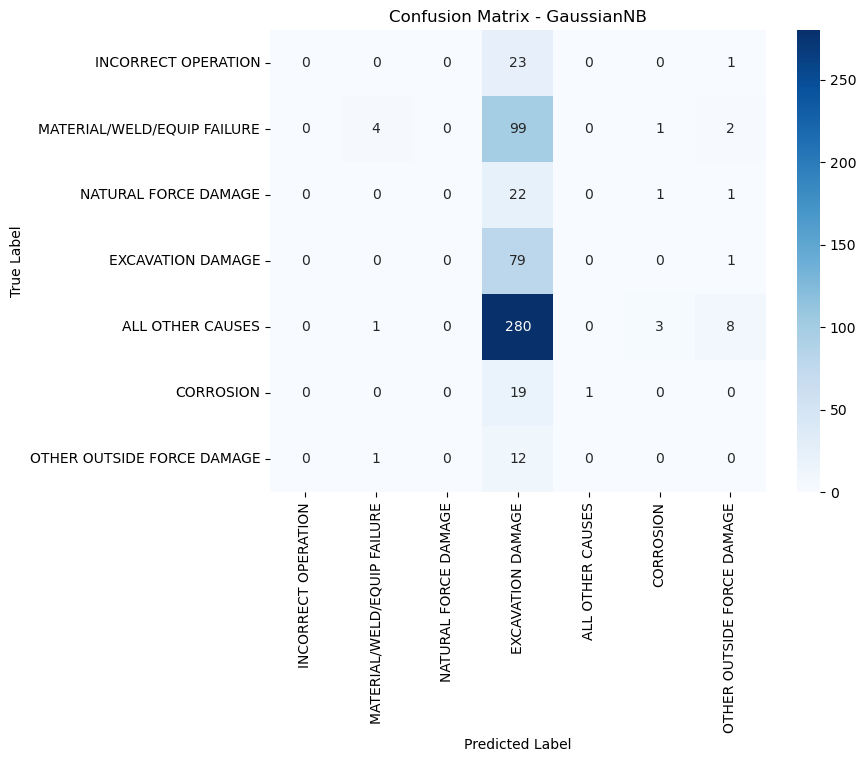

In [24]:
# قائمة النماذج
models = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced', n_jobs=-1),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000), #زيادة المحاولات
     'SVC': SVC(kernel='linear', C=1.0, probability=True, random_state=42),  # إضافة نموذج SVC
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),  # إضافة نموذج KNeighbors
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=10, random_state=42),  # إضافة نموذج Decision Tree
    'GaussianNB': GaussianNB()  # إضافة نموذج Naive Bayes

}

# استخدام StratifiedKFold للتحقق المتقاطع
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{name} (Cause Prediction):")

    # التدريب والتقييم باستخدام cross-validation
    scores = cross_val_score(model, X_train_leak_cause, y_train_leak_cause, cv=cv, scoring='accuracy')
    print(f"  Cross-Validation Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

    # التدريب على كامل بيانات التدريب
    model.fit(X_train_leak_cause, y_train_leak_cause)

    # التنبؤ على بيانات التحقق
    y_cause_pred = model.predict(X_test_leak_cause)

    # مقاييس الأداء
    print(f"  Accuracy (Validation): {accuracy_score(y_test_leak_cause, y_cause_pred):.2f}")
    print(classification_report(y_test_leak_cause, y_cause_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test_leak_cause, y_cause_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df['Cause Category'].unique(), yticklabels=df['Cause Category'].unique())
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# ---  نموذج التنبؤ بالتكاليف ---

In [25]:
# تحديد الأعمدة التي ستُستخدم كميزات (X)
features_costs = [
    'Accident_Year',
    'Accident_Month',
    'Accident_Day',
    'Accident_Hour',
    'Accident_DayOfWeek',
    'Pipeline/Facility Name',
    'Pipeline Type',
    'Liquid Type',
    'Accident City',
    'Accident County',
    'Accident State',
    'Accident Latitude',
    'Accident Longitude',
    'Cause Subcategory',  # تم تحويلها بالفعل إلى أرقام
    'Unintentional Release (Barrels)',
    'Liquid Recovery (Barrels)',
    'Net Loss (Barrels)',
    'Liquid Ignition',
    'Pipeline Shutdown',
    'Public Evacuations',
    'Lat_Lon_Distance',
    'Net_Loss_Ignition',
    'Lost Commodity Costs',
    'Public/Private Property Damage Costs',
    'Emergency Response Costs',
    'Environmental Remediation Costs',
    'Other Costs',
    'Property Damage Costs'
]
Top_features_costs = [
    'Property Damage Costs',
    'Pipeline Type',
    'Other Costs',
    'Environmental Remediation Costs',
    'Emergency Response Costs',
    'Public/Private Property Damage Costs',
    'Lost Commodity Costs',
    'Liquid Recovery (Barrels)',
    'Unintentional Release (Barrels)',
    'Net Loss (Barrels)'
]
# إنشاء مصفوفة الميزات (X)
X_costs = df[Top_features_costs]
X_costs
# تحديد المتغيرات المستهدفة (y)
y_costs = df['All Costs']  # التكلفة الإجمالية

## اعادة معالجة القيم المتطرفة 

In [26]:
def winsorize(series, lower_percentile=0.01, upper_percentile=0.99):
    """
    Winsorizes a Pandas Series by capping and flooring outliers.

    Args:
    series: Pandas Series to winsorize.
    lower_percentile: The lower percentile to use for flooring.
    upper_percentile: The upper percentile to use for capping.

    Returns:
    A new Pandas Series with outliers replaced.
    """
    lower_bound = series.quantile(lower_percentile)
    upper_bound = series.quantile(upper_percentile)
    return series.clip(lower=lower_bound, upper=upper_bound)


y_costs = winsorize(y_costs) # Apply to target variable


numerical_cols = X_costs.select_dtypes(include=np.number).columns

for col in numerical_cols:
    X_costs[col] = winsorize(X_costs[col])

# 2. تطبيق تحويلات غير خطية (Non-linear Transformations)
#  سنستخدم  log1p  و  sqrt  على الأعمدة المناسبة.
#  ملاحظات مهمة:
#  *  نتأكد من أن القيم موجبة قبل تطبيق  log  أو  sqrt
#  *  لا نطبق التحويل على أعمدة  binary  (0 or 1).

for col in numerical_cols:
    # Skip binary columns
    if set(X_costs[col].unique()) == {0, 1}:
        continue
    # Ensure positivity for log and sqrt transformations
    if X_costs[col].min() >= 0:
         # Apply log1p transformation
        X_costs[col] = np.log1p(X_costs[col])

        # Apply square root transformation (optional, can comment out)
        # X_costs[col] = np.sqrt(X_costs[col])

# Apply log transformation to y_costs if it's not already done:
if y_costs.min() >=0:
  y_costs = np.log1p(y_costs)

In [27]:
numerical_columns = [col for col in X_costs.columns if X_costs[col].dtype in ['int32','float64','int64']]
scaler = StandardScaler()
X_costs[numerical_columns] = scaler.fit_transform(X_costs[numerical_columns])

X_train_costs, X_test_costs, y_train_costs, y_test_costs = train_test_split(
    X_costs, y_costs, test_size=0.2, random_state=42)
X_costs

Property Damage Costs  Pipeline Type  Other Costs  Environmental Remediation Costs  Emergency Response Costs  Public/Private Property Damage Costs  Lost Commodity Costs  Liquid Recovery (Barrels)  Unintentional Release (Barrels)  Net Loss (Barrels)
0                 -0.575223      -0.887647    -0.353740                        -1.054297                 -1.430158                             -0.315548              0.839422                  -0.768946                         0.544096            1.215811
1                  0.284810      -0.887647    -0.353740                        -1.054297                 -1.430158                             -0.315548             -0.831764                  -0.706684                        -0.906779           -0.535133
2                 -1.705100      -0.887647    -0.353740                        -1.054297                 -1.430158                             -0.315548              0.180505                  -0.768946                        -0.426705            0.087184
3                 -0.432769       1.273141    -0.353740                        -1.054297                  0.637074                             -0.315548             -0.337588                  -0.553560                        -0.770977           -0.535133
4                  0.670887       1.273141    -0.353740                         0.464821                  0.546289                             -0.315548              0.087290                   2.829387                         2.230676            0.087184
...                     ...            ...          ...                              ...                       ...                                   ...                   ...                        ...                              ...                 ...
2790              -1.705100      -0.887647    -0.353740                         1.147747                 -1.430158                             -0.315548             -0.644253                  -0.646352                        -0.853272           -0.535133
2791              -1.705100       1.273141     3.516996                        -1.054297                 -1.430158                             -0.315548              1.253050                  -0.768946                         2.139192            3.070228
2792               0.419043       0.192747    -0.353740                         0.545819                  0.456491                             -0.315548             -0.266459                  -0.388135                        -0.624266           -0.535133
2793               0.545364       1.273141    -0.353740                        -1.054297                  0.850103                             -0.315548             -0.738009                  -0.668779                        -0.873163           -0.535133
2794               0.868610      -0.887647    -0.353740                        -1.054297                 -1.430158                             -0.315548              0.180505                   0.115268                        -0.177808           -0.535133

[2795 rows x 10 columns]

In [28]:
# 1. RandomForestRegressor
print("\nRandomForestRegressor (All Costs Prediction):")
model_costs_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model_costs_rf.fit(X_train_costs, y_train_costs)
y_costs_pred_rf = model_costs_rf.predict(X_test_costs)
rmse_costs_rf = np.sqrt(mean_squared_error(y_test_costs, y_costs_pred_rf))
r2_costs_rf = r2_score(y_test_costs, y_costs_pred_rf)
print(f"  RMSE (Validation): {rmse_costs_rf:.2f}")
print(f"  R-squared (Validation): {r2_costs_rf:.2f}")

# 2. GradientBoostingRegressor
print("\nGradientBoostingRegressor (All Costs Prediction):")
model_costs_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_costs_gb.fit(X_train_costs, y_train_costs)
y_costs_pred_gb = model_costs_gb.predict(X_test_costs)
rmse_costs_gb = np.sqrt(mean_squared_error(y_test_costs, y_costs_pred_gb))
r2_costs_gb = r2_score(y_test_costs, y_costs_pred_gb)
print(f"  RMSE (Validation): {rmse_costs_gb:.2f}")
print(f"  R-squared (Validation): {r2_costs_gb:.2f}")

# 3. SVR (Support Vector Regressor)
print("\nSVR (All Costs Prediction):")
model_costs_svr = SVR()  # القيم الافتراضية
model_costs_svr.fit(X_train_costs, y_train_costs)
y_costs_pred_svr = model_costs_svr.predict(X_test_costs)
rmse_costs_svr = np.sqrt(mean_squared_error(y_test_costs, y_costs_pred_svr))
r2_costs_svr = r2_score(y_test_costs, y_costs_pred_svr)
print(f"  RMSE (Validation): {rmse_costs_svr:.2f}")
print(f"  R-squared (Validation): {r2_costs_svr:.2f}")

# 4. KNeighborsRegressor
print("\nKNeighborsRegressor (All Costs Prediction):")
model_costs_knr = KNeighborsRegressor()  # القيم الافتراضية
model_costs_knr.fit(X_train_costs, y_train_costs)
y_costs_pred_knr = model_costs_knr.predict(X_test_costs)
rmse_costs_knr = np.sqrt(mean_squared_error(y_test_costs, y_costs_pred_knr))
r2_costs_knr = r2_score(y_test_costs, y_costs_pred_knr)
print(f"  RMSE (Validation): {rmse_costs_knr:.2f}")
print(f"  R-squared (Validation): {r2_costs_knr:.2f}")

# 5. DecisionTreeRegressor
print("\nDecisionTreeRegressor (All Costs Prediction):")
model_costs_dtr = DecisionTreeRegressor(random_state=42)  # القيم الافتراضية
model_costs_dtr.fit(X_train_costs, y_train_costs)
y_costs_pred_dtr = model_costs_dtr.predict(X_test_costs)
rmse_costs_dtr = np.sqrt(mean_squared_error(y_test_costs, y_costs_pred_dtr))
r2_costs_dtr = r2_score(y_test_costs, y_costs_pred_dtr)
print(f"  RMSE (Validation): {rmse_costs_dtr:.2f}")
print(f"  R-squared (Validation): {r2_costs_dtr:.2f}")

# 6. XGBRegressor
print("\nXGBRegressor (All Costs Prediction):")
model_costs_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_costs_xgb.fit(X_train_costs, y_train_costs)
y_costs_pred_xgb = model_costs_xgb.predict(X_test_costs)
rmse_costs_xgb = np.sqrt(mean_squared_error(y_test_costs, y_costs_pred_xgb))
r2_costs_xgb = r2_score(y_test_costs, y_costs_pred_xgb)
print(f"  RMSE (Validation): {rmse_costs_xgb:.2f}")
print(f"  R-squared (Validation): {r2_costs_xgb:.2f}")

# 7. HistGradientBoostingRegressor
print("\nHistGradientBoostingRegressor (All Costs Prediction):")
model_costs_hgb = HistGradientBoostingRegressor(random_state=42)  # القيم الافتراضية
model_costs_hgb.fit(X_train_costs, y_train_costs)
y_costs_pred_hgb = model_costs_hgb.predict(X_test_costs)
rmse_costs_hgb = np.sqrt(mean_squared_error(y_test_costs, y_costs_pred_hgb))
r2_costs_hgb = r2_score(y_test_costs, y_costs_pred_hgb)
print(f"  RMSE (Validation): {rmse_costs_hgb:.2f}")
print(f"  R-squared (Validation): {r2_costs_hgb:.2f}")

# 8. CatBoostRegressor
print("\nCatBoostRegressor (All Costs Prediction):")
model_costs_cat = CatBoostRegressor(verbose=0, random_state=42)  # verbose=0 لإخفاء المخرجات
model_costs_cat.fit(X_train_costs, y_train_costs)
y_costs_pred_cat = model_costs_cat.predict(X_test_costs)
rmse_costs_cat = np.sqrt(mean_squared_error(y_test_costs, y_costs_pred_cat))
r2_costs_cat = r2_score(y_test_costs, y_costs_pred_cat)
print(f"  RMSE (Validation): {rmse_costs_cat:.2f}")
print(f"  R-squared (Validation): {r2_costs_cat:.2f}")


RandomForestRegressor (All Costs Prediction):
  RMSE (Validation): 0.58
  R-squared (Validation): 0.95

GradientBoostingRegressor (All Costs Prediction):
  RMSE (Validation): 0.76
  R-squared (Validation): 0.92

SVR (All Costs Prediction):
  RMSE (Validation): 0.65
  R-squared (Validation): 0.94

KNeighborsRegressor (All Costs Prediction):
  RMSE (Validation): 0.94
  R-squared (Validation): 0.88

DecisionTreeRegressor (All Costs Prediction):
  RMSE (Validation): 0.60
  R-squared (Validation): 0.95

XGBRegressor (All Costs Prediction):
  RMSE (Validation): 0.75
  R-squared (Validation): 0.92

HistGradientBoostingRegressor (All Costs Prediction):
  RMSE (Validation): 0.48
  R-squared (Validation): 0.97

CatBoostRegressor (All Costs Prediction):
  RMSE (Validation): 0.47
  R-squared (Validation): 0.97


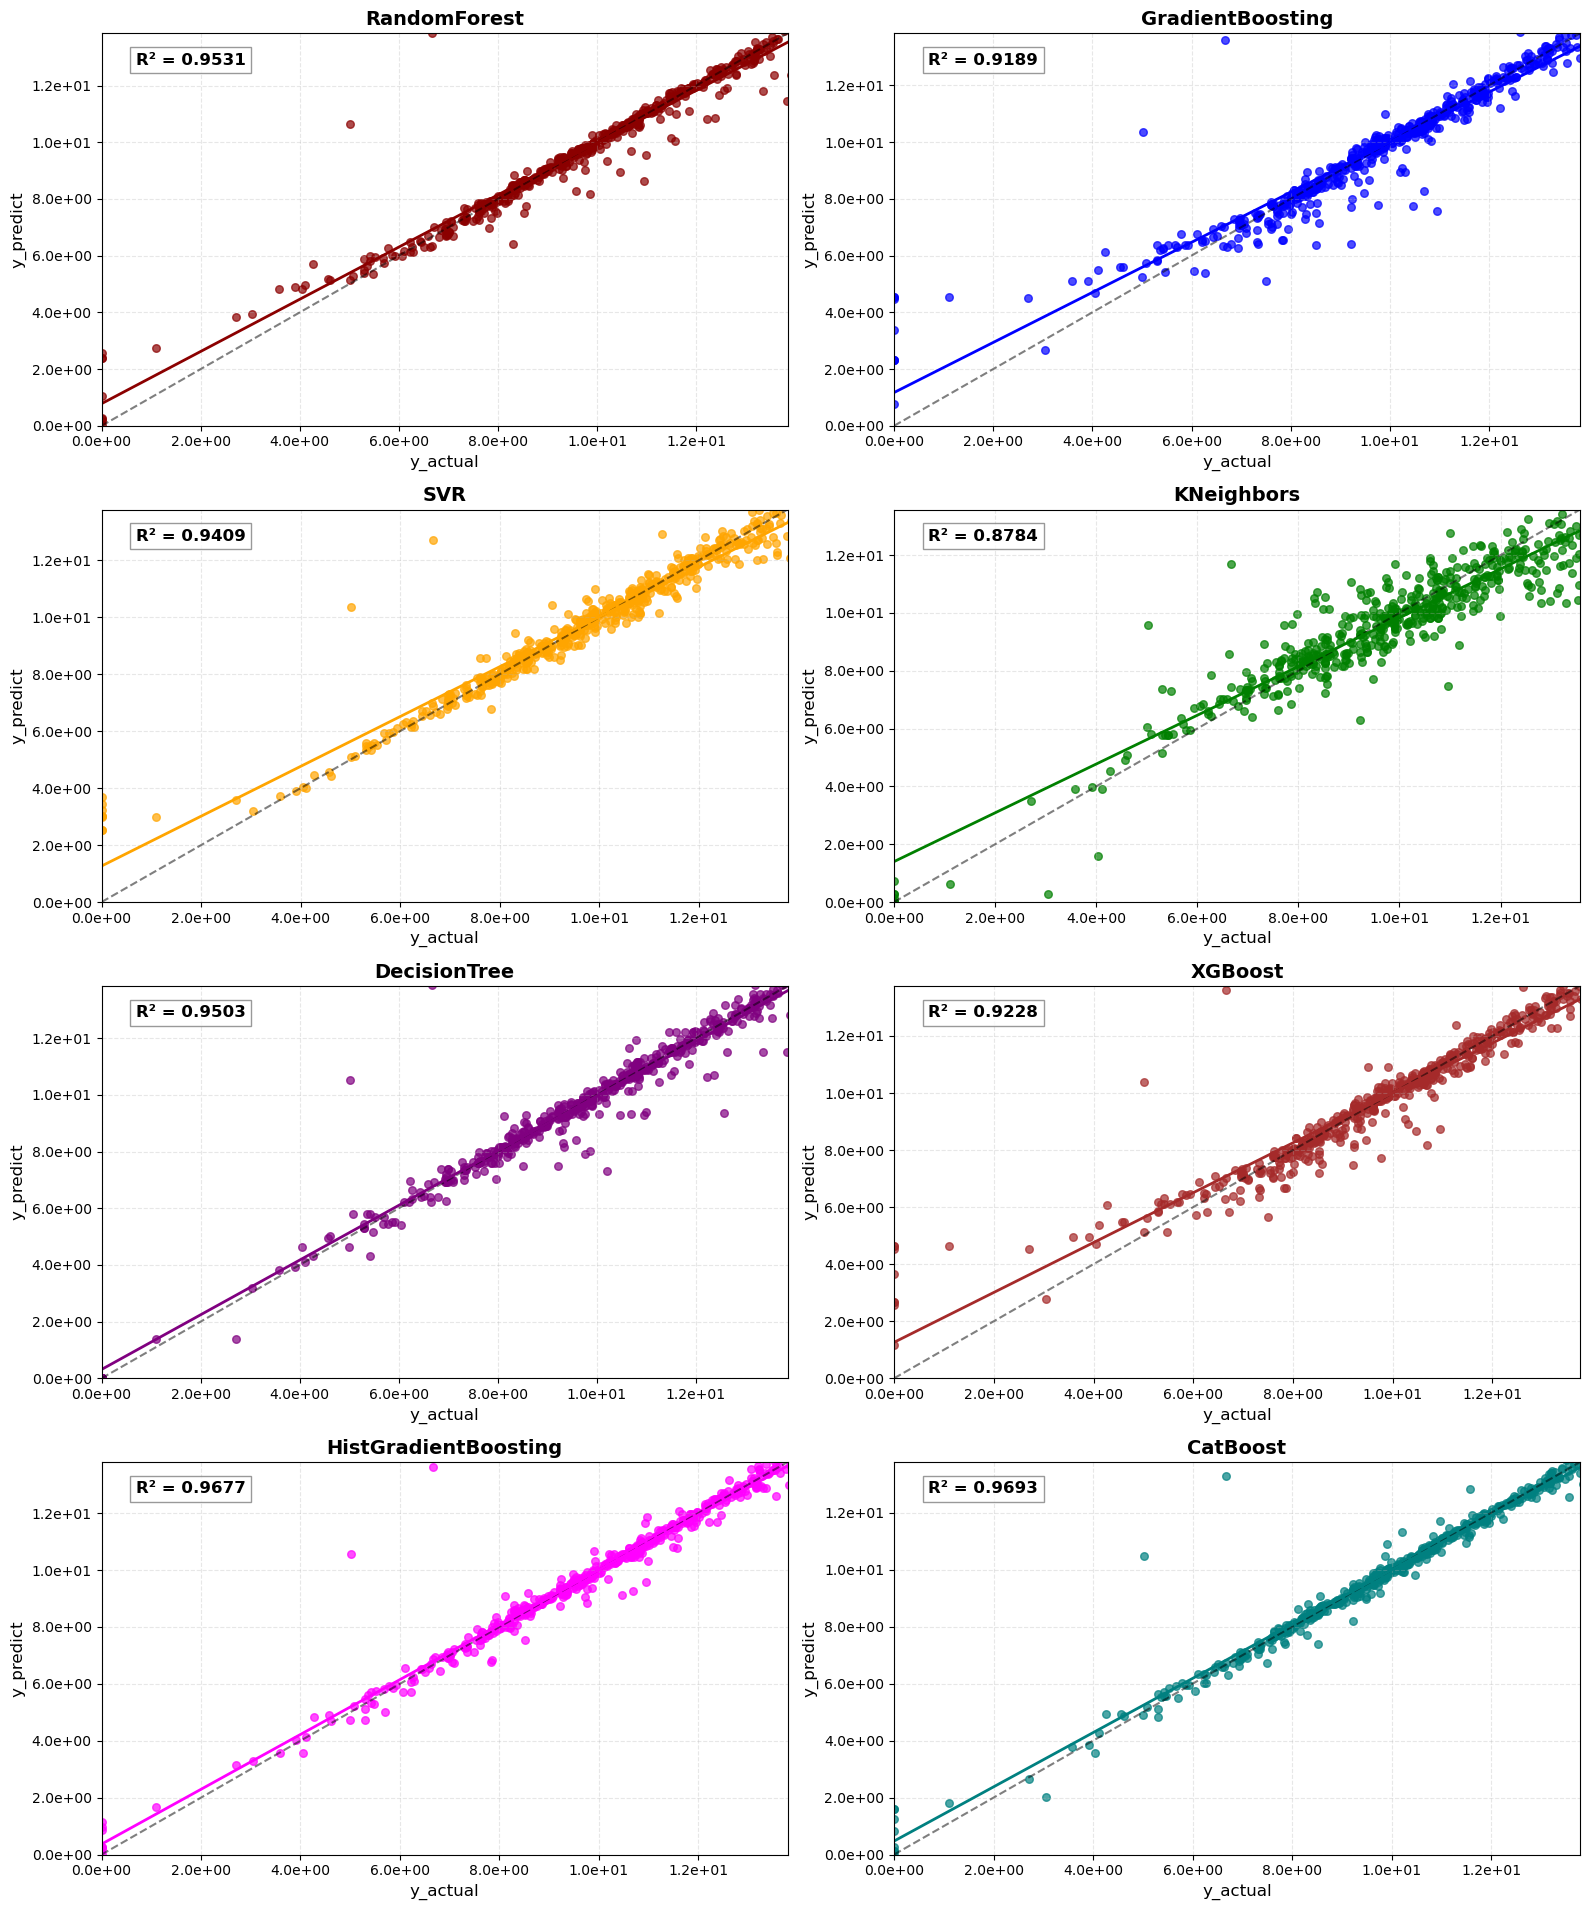

In [29]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))

# تعريف الخوارزميات والتنبؤات المقابلة مع قيم R-squared
algorithms = [
    ('RandomForest', y_costs_pred_rf, y_test_costs, r2_costs_rf, 'darkred'),
    ('GradientBoosting', y_costs_pred_gb, y_test_costs, r2_costs_gb, 'blue'),
    ('SVR', y_costs_pred_svr, y_test_costs, r2_costs_svr, 'orange'),
    ('KNeighbors', y_costs_pred_knr, y_test_costs, r2_costs_knr, 'green'),
    ('DecisionTree', y_costs_pred_dtr, y_test_costs, r2_costs_dtr, 'purple'),
    ('XGBoost', y_costs_pred_xgb, y_test_costs, r2_costs_xgb, 'brown'),
    ('HistGradientBoosting', y_costs_pred_hgb, y_test_costs, r2_costs_hgb, 'magenta'),
    ('CatBoost', y_costs_pred_cat, y_test_costs, r2_costs_cat, 'teal')
]

# رسم كل خوارزمية
for i, (name, y_pred, y_true, r2, color) in enumerate(algorithms):
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    # رسم البيانات
    ax.scatter(y_true, y_pred, alpha=0.7, s=30, color=color)
    
    # تحديد الحد الأقصى المشترك للمحاور
    all_values = np.concatenate([y_true, y_pred])
    max_val = np.percentile(all_values, 95)  # استخدام 99.5% من القيم لتجنب القيم المتطرفة جداً
    
    # تعيين نطاق المحاور
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    
    # رسم خط الانحدار المثالي (y=x)
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
    
    # رسم خط الانحدار الفعلي
    coef = np.polyfit(y_true, y_pred, 1)
    poly1d_fn = np.poly1d(coef)
    ax.plot([0, max_val], [poly1d_fn(0), poly1d_fn(max_val)], '-', color=color, linewidth=2)
    
    # تنسيق المحاور لعرض القيم العلمية بطريقة أفضل
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.1e}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.1e}'))
    
    # إضافة قيمة R²
    ax.text(0.05, 0.92, f'R² = {r2:.4f}', transform=ax.transAxes, 
            fontsize=12, fontweight='bold', color='black', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # تسمية المحاور والعنوان
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.set_xlabel('y_actual', fontsize=12)
    ax.set_ylabel('y_predict', fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--')
   
# ضبط المساحات بين الرسوم البيانية
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('algorithms_predictions_comparison_with_r2.png', dpi=300, bbox_inches='tight')
plt.show()